In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
c=3e8
pi=np.pi

In [151]:
 def hexShell(nside,d):
    points=[]
    if(nside>1):
        for m in range(nside):
            x=(.5+m/(2.*(nside-1.)))*d*nside
            y=np.sqrt(3.)*(x-.5*d*nside)-np.sqrt(3.)*d*nside/2.
            points.append([x,y])
            points.append([x-d*nside*3./2.,y+np.sqrt(3.)*d*nside/2.])
        for m in range(nside-1):
            x=(.5+m/(2.*(nside-1.)))*d*nside
            y=-np.sqrt(3.)*(x-.5*d*nside)+np.sqrt(3.)*d*nside/2.
            points.append([x,y])
            points.append([x-d*nside*3./2.+d*nside/(nside-1.)/2.,y-np.sqrt(3.)*d*nside/2.-d*nside/(nside-1.)*np.sqrt(3.)/2.])
        for m in range(1,nside-1):
            x=(-.5+m/(1.*nside-1.))*d*nside
            y=np.sqrt(3.)/2.*d*nside
            points.append([x,y])
            points.append([x,y-d*nside*np.sqrt(3.)])
    elif(nside==0):
        return np.array([[0,0]])
    elif(nside==1):
        return d*np.array([[-.5,np.sqrt(3.)/2.],[.5,np.sqrt(3.)/2.],[-1.,0.],[1.,0.],[-.5,-np.sqrt(3.)/2.],[.5,-np.sqrt(3.)/2.]])
    return np.array(points)
def hexPack(nshell,d):
    output=hexShell(0,d)
    for m in range(2,nshell+1):
        output=np.vstack([output,hexShell(m,(1.-1./m)*d)])
    return output

def gridPack(nx,ny,d):
    output=n.zeros((nx,ny))
    jj=0
    for mm in range(nx):
        for nn in range(ny):
            output[jj,0]=mm*d
            output[jj,1]=nn*d

In [54]:
def perturbPositions(aP,dAp):
    return aP-dAp+2.*dAp*np.random.rand(*(dAp.shape))

In [114]:
def dishKernel(r,R):
    if(len(r)>1):
        output=np.zeros(r.shape)
        selection=r<=R
        output[selection]+=2./(np.pi)*(np.arccos(r[selection]/R)-(r[selection]/R)*np.sqrt(1-(r[selection]/R)**2.))
        return output
    else:
        return 2./(np.pi)*(np.arccos(r/R)-(r/R)*np.sqrt(1-(r/R)**2.))
    


In [225]:
def grid(nx,ny,dx,dy,posX,posY,data,kernelFunction,kernelSize=None):
    if(kernelSize is None):
        kernelSize=max(nx,ny)
    griddedData=np.zeros((nx,ny))
    nData=len(data)
    xGrid,yGrid=np.meshgrid(np.arange(nx)*dx,np.arange(ny)*dy)
    xGrid-=ny*dy/2.
    yGrid-=nx*dx/2.
    for mm in range(nData):
        #identify points within kernel
        dX=posX[mm]-xGrid
        dY=posY[mm]-yGrid
        pointsToAdd=np.logical_and(np.abs(dX/dx)<=kernelSize/2,np.abs(dY/dy)<=kernelSize/2.)
        griddedData[pointsToAdd]+=kernelFunction(dX[pointsToAdd],dY[pointsToAdd])*data[mm]
        dX=-posX[mm]-xGrid
        dY=-posY[mm]-yGrid
        pointsToAdd=np.logical_and(np.abs(dX/dx)<=kernelSize/2,np.abs(dY/dy)<=kernelSize/2.)
        griddedData[pointsToAdd]+=kernelFunction(dX[pointsToAdd],dY[pointsToAdd])*data[mm]



    return griddedData
    
    

In [226]:
print nDish

331


In [239]:
#generate array
dAnt=2.
dAntPos=5.
antPos=hexPack(11,dAntPos)
antPosP=perturbPositions(antPos,np.ones(antPos.shape)*2.)
cFreq=150e6
nDish=len(antPos)

nVis=nDish*(nDish-1)/2
antDiff=np.zeros((nVis,2))
antDiffP=np.zeros_like(antDiff)
dIndex=0
for iDish in range(nDish):
    for jDish in range(iDish):
        antDiff[dIndex,0]=antPos[iDish,0]-antPos[jDish,0]
        antDiff[dIndex,1]=antPos[iDish,1]-antPos[jDish,1]
        antDiffP[dIndex,0]=antPosP[iDish,0]-antPosP[jDish,0]
        antDiffP[dIndex,1]=antPosP[iDish,1]-antPosP[jDish,1]
        dIndex+=1
uvDis=antDiff/(c/cFreq)
uvDisP=antDiffP/(c/cFreq)

uvAmp=np.sqrt(np.sum(uvDis**2.,axis=1))
uvPAmp=np.sqrt(np.sum(uvDisP**2.,axis=1))
maxUV=max(uvAmp.max(),uvPAmp.max())
gridSize=int(np.ceil(4.*maxUV))
if(np.mod(gridSize,2)==1):
    gridSize+=1
kernelFunc=lambda dx,dy: dishKernel(np.sqrt(dx**2.+dy**2.),dAnt/2./(c/cFreq))
uvGrid=grid(gridSize,gridSize,0.5,0.5,uvDis[:,0],uvDis[:,1],np.ones(nVis),kernelFunc,2.*dAnt/(c/cFreq))
uvGridP=grid(gridSize,gridSize,0.5,0.5,uvDisP[:,0],uvDisP[:,1],np.ones(nVis),kernelFunc,2.*dAnt/(c/cFreq))

In [240]:
psf=np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(uvGrid))));psf/=psf.max()
psfP=np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(uvGridP))));psfP/=psfP.max()

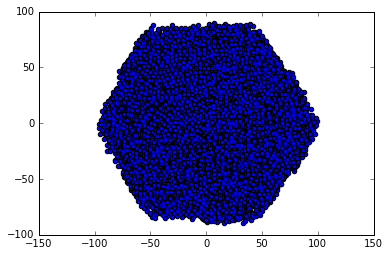

In [241]:
plt.scatter(antDiffP[:,0],antDiffP[:,1])

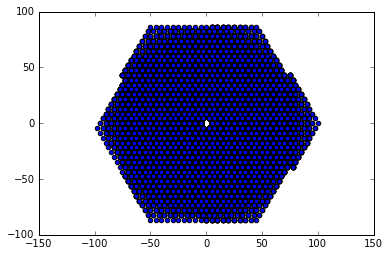

In [242]:
plt.scatter(antDiff[:,0],antDiff[:,1])

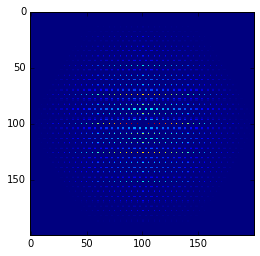

In [243]:
plt.imshow(uvGrid,interpolation='nearest')

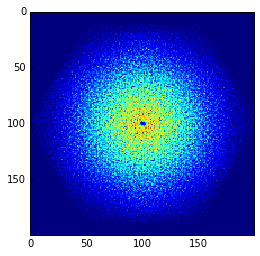

In [244]:
plt.imshow(uvGridP,interpolation='nearest')

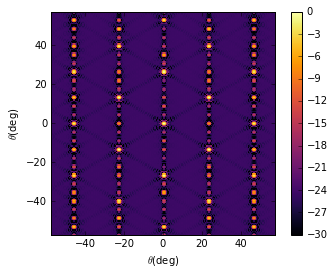

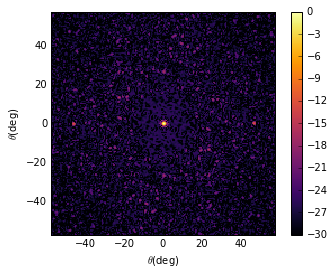

In [245]:
dtheta=180./pi*1./(0.5*gridSize)

plt.imshow(10.*np.log10(np.abs(psf)),interpolation='nearest',vmin=-30,vmax=0,cmap='inferno',extent=[-dtheta/2*gridSize,dtheta/2*gridSize,-dtheta/2*gridSize,dtheta/2*gridSize])
plt.colorbar()
plt.xlabel('$\\theta$(deg)')
plt.ylabel('$\\theta$(deg)')
plt.show()
plt.imshow(10.*np.log10(np.abs(psfP)),interpolation='nearest',vmin=-30,vmax=0,cmap='inferno',extent=[-dtheta/2*gridSize,dtheta/2*gridSize,-dtheta/2*gridSize,dtheta/2*gridSize])
plt.colorbar()
plt.xlabel('$\\theta$(deg)')
plt.ylabel('$\\theta$(deg)')
plt.show()